# Plotting Receptor Dose Response

This notebook is just for plotting an example "receptor" dose response. 



In [75]:
TARGET_RECEPTOR_TO_PLOT = 'TP53'
ENDPOINTS = ['human_hc', 'human_hb']
org = "human"

In [76]:
import pandas as pd, numpy as np
import pymongo

client = pymongo.MongoClient()

pipe = [
    {"$match": {"$and": [{"_id.type": org},  {"_id.aop": TARGET_RECEPTOR_TO_PLOT}]}},
    { "$project": {
        "_id": 0, 
        "mechanism": "$_id.mechanism",
        "receptor": "$_id.aop",
        "casn": "$_id.casn",
        "auc_score": "$auc_norm",
        "receptor_conc_score": "$responses_norm",
         "conc": "$concentrations"
    }}
]
receptor_scores = pd.DataFrame(list(client.LiverToxCast.ke_models.aggregate(pipe)))



pipe = [
    {"$match": {"mechanism_group2": TARGET_RECEPTOR_TO_PLOT}},
    {"$match": {"endpoint": {'$in': ENDPOINTS}}},
    {
        "$project": {
            "aeid": "$aeid",
            "mechanism": "$mechanism_group",
            "_id": 0
        }
    }
]


receptor_aeids = pd.DataFrame(client.LiverToxCast.endpoint_aeid_pvalues.aggregate(pipe)).drop_duplicates()




In [77]:
receptor_scores.head()

,receptor,casn,auc_score,receptor_conc_score,conc
0,TP53,100-00-5,0.000000,"[1.1787350651104589e-08, -1.715581099404062e-0...","[1e-06, 2.679636e-06, 4.019455e-06, 6.029182e-..."
1,TP53,100-01-6,0.000000,"[-9.675206058545882e-08, -2.0505508402379746e-...","[1e-06, 2.679636e-06, 4.019455e-06, 6.029182e-..."
2,TP53,100-02-7,0.005102,"[-1.0296919761287882e-08, 5.827286599924264e-0...","[1e-06, 2.679636e-06, 4.019455e-06, 6.029182e-..."
3,TP53,100-06-1,-0.000000,"[-1.559413398410925e-08, -1.2591253373273048e-...","[1e-06, 2.679636e-06, 4.019455e-06, 6.029182e-..."
4,TP53,100-10-7,-0.000000,"[1.6672640157366914e-08, -5.110838330324441e-0...","[1e-06, 2.679636e-06, 4.019455e-06, 6.029182e-..."


In [78]:
casrns = receptor_scores.casn.tolist()

dr_results  = list(client.LiverToxCast.best_models.find({'$and': [{'_id.aeid': {'$in': receptor_aeids.aeid.tolist()}}, 
                                            {'_id.casn': {'$in': casrns}}]}))


reformat = [{'aeid': r['_id']['aeid'], 'casn': r['_id']['casn'], 'responses': r['responses']}
           for r in dr_results]

CONC_LIST = dr_results[0]['concentrations']
cr_frame = pd.DataFrame(reformat)

In [79]:

cr_frame['conc'] = [CONC_LIST for _ in range(len(cr_frame))]
cr_frame = cr_frame.set_index(['aeid' , 'casn']).apply(pd.Series.explode).reset_index()


max_responses = cr_frame.groupby('aeid').responses.max()

for aeid, max_response in max_responses.iteritems():
    cr_frame.loc[cr_frame.aeid == aeid, 'responses'] = cr_frame.loc[cr_frame.aeid == aeid, 'responses'] * (1/max_response)


In [80]:
cr_frame.head()

,aeid,casn,responses,conc
0,60,100-01-6,0.0,0.000001
1,60,100-01-6,0.0,0.000003
2,60,100-01-6,0.0,0.000004
3,60,100-01-6,0.0,0.000006
4,60,100-01-6,0.0,0.000009


In [81]:
idx=98

high_auc_casn = receptor_scores.sort_values('auc_score').iloc[-idx].casn
high_auc_score = receptor_scores.sort_values('auc_score').iloc[-idx].auc_score
best_receptor = receptor_scores[receptor_scores.casn == high_auc_casn]

receptor_score = best_receptor[['receptor_conc_score', 'conc']].apply(pd.Series.explode)
receptor_score.columns = ['Response', 'Concentration']

for col in receptor_score.columns:
    receptor_score[col] = receptor_score[col].astype(float)



In [82]:
high_auc_casn

'17406-45-0'

In [83]:
    
aeid_scores = cr_frame[cr_frame.casn == high_auc_casn]

for aeid in receptor_aeids:
    if aeid not in aeid_scores.aeid.values:
        data = []
        for conc in CONC_LIST:
            row_data = [aeid, high_auc_casn, [0], conc]
            df = pd.DataFrame(data =row_data).T
            df.columns = aeid_scores.columns
            aeid_scores = aeid_scores.append(df)


# aeid_scores['conc'] = [CONC_LIST for _ in range(len(aeid_scores))]

aeid_scores.columns = ['ToxCast/Tox21 Assay ID', 'CASRN', 'Response', 'Concentrations']
# aeid_scores = aeid_scores.drop('CASRN', axis=1)

aeid_scores = aeid_scores.set_index('ToxCast/Tox21 Assay ID').apply(pd.Series.explode).reset_index()
for col in ['Response', 'Concentrations']:
    aeid_scores[col] = aeid_scores[col].astype(float)


/opt/anaconda3/envs/toxcast/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


In [84]:
aeid_scores.head()

,ToxCast/Tox21 Assay ID,CASRN,Response,Concentrations
0,1116,17406-45-0,1.642127e-08,0.000001
1,1116,17406-45-0,4.331246e-08,0.000003
2,1116,17406-45-0,6.454735e-08,0.000004
3,1116,17406-45-0,9.619306e-08,0.000006
4,1116,17406-45-0,1.433538e-07,0.000009


In [85]:
aeid_scores = aeid_scores[~aeid_scores['ToxCast/Tox21 Assay ID'].isin(['mechanism', 'aeid'])]

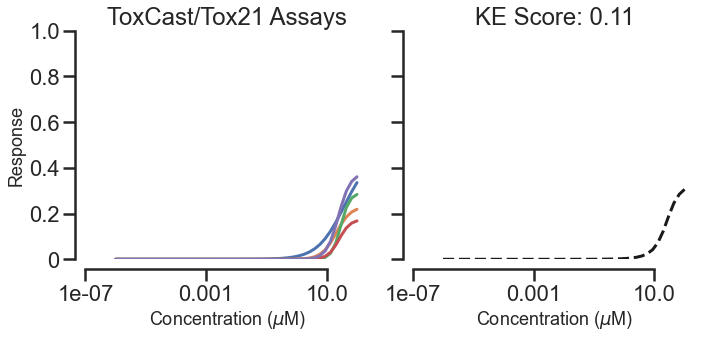

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
sns.set_context('poster')

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

axarr[1] = sns.lineplot(data=receptor_score, x="Concentration", y="Response", ax=axarr[1], legend=False, label='{} Receptor;\nAUC Score: {:.2f}'.format('ER Antagonism', high_auc_score), color='k', lw=3, ls='--')

sns.set_context("poster")

axarr[0] = sns.lineplot(data=aeid_scores, x="Concentrations", y="Response", hue='ToxCast/Tox21 Assay ID', legend=False, palette="deep", ax=axarr[0], lw=3)

axarr[0].set(xscale="log")
axarr[1].set(xscale="log")

axarr[0].set_ylim(0, 1)
axarr[1].set_ylim(0, 1)


yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

for i in [0, 1]:
    axarr[i].set_yticks(yticks)
    axarr[i].set_yticklabels(yticks, fontsize=14)


xticks = axarr[0].get_xticks()[1:-2]
for i in [0, 1]:
    axarr[i].set_xticks(xticks)
    axarr[i].set_xticklabels(xticks, fontsize=14)
    axarr[i].set_ylabel('Response', fontsize=18)
    axarr[i].set_xlabel('Concentration ($\mu$M)', fontsize=18)



axarr[0].set_title('ToxCast/Tox21 Assays')
axarr[1].set_title('KE Score: {:.2f}'.format(high_auc_score))

# plt.legend(handles=[], loc=2, prop={"size":20})
plt.tight_layout()
sns.despine(offset=10, trim=True);
plt.savefig('../data/figures/{}_{}.png'.format(TARGET_RECEPTOR_TO_PLOT, high_auc_casn), transparent=True)

In [87]:
for_scatter = receptor_scores.sort_values('auc_score', ascending=False)
for_scatter['Rank']  = list(range(1, for_scatter.shape[0]+1))

In [69]:
SCATTER_COLOR = 'grey'
N = 150
#N = 100

In [88]:
TITLE = 'KE 3 (TP53)'
#TITLE = 'KE 4 (ER Antagonism)'

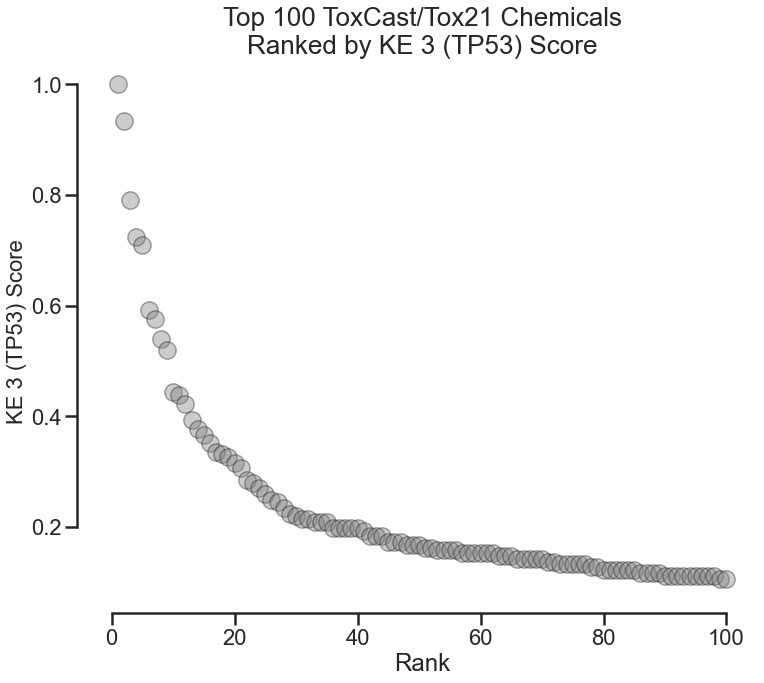

In [89]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
sns.set()
sns.set_style("ticks")
sns.set_context('poster')


for_scatter2 = for_scatter.rename({'auc_score': "{} Receptor Score".format(TARGET_RECEPTOR_TO_PLOT)}, axis=1)


axarr = sns.scatterplot(data=for_scatter2.iloc[:N], 
                        x="Rank", y="{} Receptor Score".format(TARGET_RECEPTOR_TO_PLOT), 
                        ax=axarr, 
                        edgecolor='k', 
                        color=SCATTER_COLOR, 
                        alpha=0.4, 
                        s=300)

axarr.set_title('Top {} ToxCast/Tox21 Chemicals\nRanked by {} Score'.format(N, TITLE), fontsize=26)
handles, labels = axarr.get_legend_handles_labels()

axarr.set_ylabel('{} Score'.format(TITLE), fontsize=22)

sns.despine(offset=10, trim=True);
plt.savefig('../data/figures/{}_scatter_plot.png'.format(TARGET_RECEPTOR_TO_PLOT), transparent=True)

In [72]:
from rdkit import Chem

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import rdkit
print(rdkit.__version__)TITLE

2020.09.1


In [53]:
chemicals = pd.DataFrame(list(client.LiverToxCast.master_chemicals.find({}, {'CASRN': 1, 'rdkitInChIClean': 1})))


In [54]:
chemicals = chemicals.rename({'CASRN': 'casn'}, axis=1)

In [55]:
high_auc_casn

'23541-50-6'

In [58]:
chemicals

,_id,rdkitInChIClean,casn
0,60d9d0cc3af87a557ec93fab,InChI=1S/2Bi.3O,1304-76-3
1,60d9d0cc3af87a557ec93fac,InChI=1S/2BrH.Ca/h2*1H;/q;;+2/p-2,7789-41-5
2,60d9d0cc3af87a557ec93fad,"InChI=1S/2C10H19NO5/c2*1-10(2,6-12)8(15)9(16)1...",17097-76-6
3,60d9d0cc3af87a557ec93fae,InChI=1S/2C12H24O2.2C4H9.Sn/c2*1-2-3-4-5-6-7-8...,77-58-7
4,60d9d0cc3af87a557ec93faf,"InChI=1S/2C2H4O2.Al.H2O/c2*1-2(3)4;;/h2*1H3,(H...",142-03-0
...,...,...,...
8402,60d9d0cc3af87a557ec9607d,InChI=1S/NO3.Tl/c2-1(3)4;/q-1;+1,10102-45-1
8403,60d9d0cc3af87a557ec9607e,"InChI=1S/Na.H2O4S/c;1-5(2,3)4/h;(H2,1,2,3,4)/q...",7681-38-1
8404,60d9d0cc3af87a557ec9607f,"InChI=1S/Ni.H2O4S/c;1-5(2,3)4/h;(H2,1,2,3,4)/q...",10101-97-0
8405,60d9d0cc3af87a557ec96080,InChI=1S/O2Se/c1-3-2,7446-08-4


In [57]:
mol = Chem.MolFromInchi(chemicals[chemicals.casn == high_auc_casn].rdkitInChIClean.iloc[0])

IndexError: single positional indexer is out-of-bounds

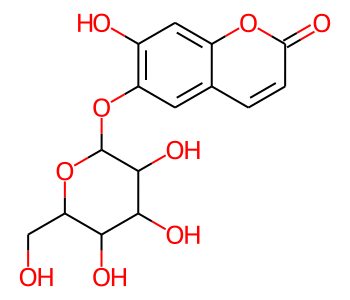

In [ ]:
d2d = rdMolDraw2D.MolDraw2DSVG(350,300)
d2d.DrawMolecule(mol)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

In [59]:
aeid_scores['ToxCast Assay ID'].unique().tolist()

[1116, 1317, 1321, 1325, 1329]

In [ ]:
high_auc_casn

'531-75-9'

In [ ]:
chemicals[chemicals.casn == '13080-86-9']

,_id,rdkitInChIClean,casn
4842,60d9d0cc3af87a557ec95295,"InChI=1S/C27H26N2O2/c1-27(2,19-3-11-23(12-4-19...",13080-86-9


In [ ]:
hb

NameError: name 'hb' is not defined

In [ ]:
for_scatter2.iloc[:100]